In [1]:
cd ..

d:\min\research_projects\FedImpute


d:\min\research_projects\FedImpute\.venv\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd
import tabulate

# Load Data

In [3]:
%load_ext autoreload
%autoreload 2

from fedimpute.data_prep import load_data, display_data, column_check
data, data_config = load_data("fed_heart_disease")

In [4]:
%load_ext autoreload
%autoreload 2
from fedimpute.scenario import Simulator

simulator = Simulator()
simulation_results = simulator.create_real_scenario(
    data, data_config,
)

simulator.summarize_scenario()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Scenario Summary
Total clients: 4
Global Test Data: (94, 21)
Missing Mechanism Category: MCAR
Clients Data Summary:
     Train     Test      Miss     MS Ratio    MS Feature    Seed
--  --------  -------  --------  ----------  ------------  ------
C1  (244,21)  (28,21)  (244,20)     0.00         0/20       6077
C2  (237,21)  (27,21)  (237,20)     0.04         4/20       577
C3  (99,21)   (11,21)  (99,20)      0.01         3/20       7231
C4  (162,21)  (18,21)  (162,20)     0.07         5/20       5504



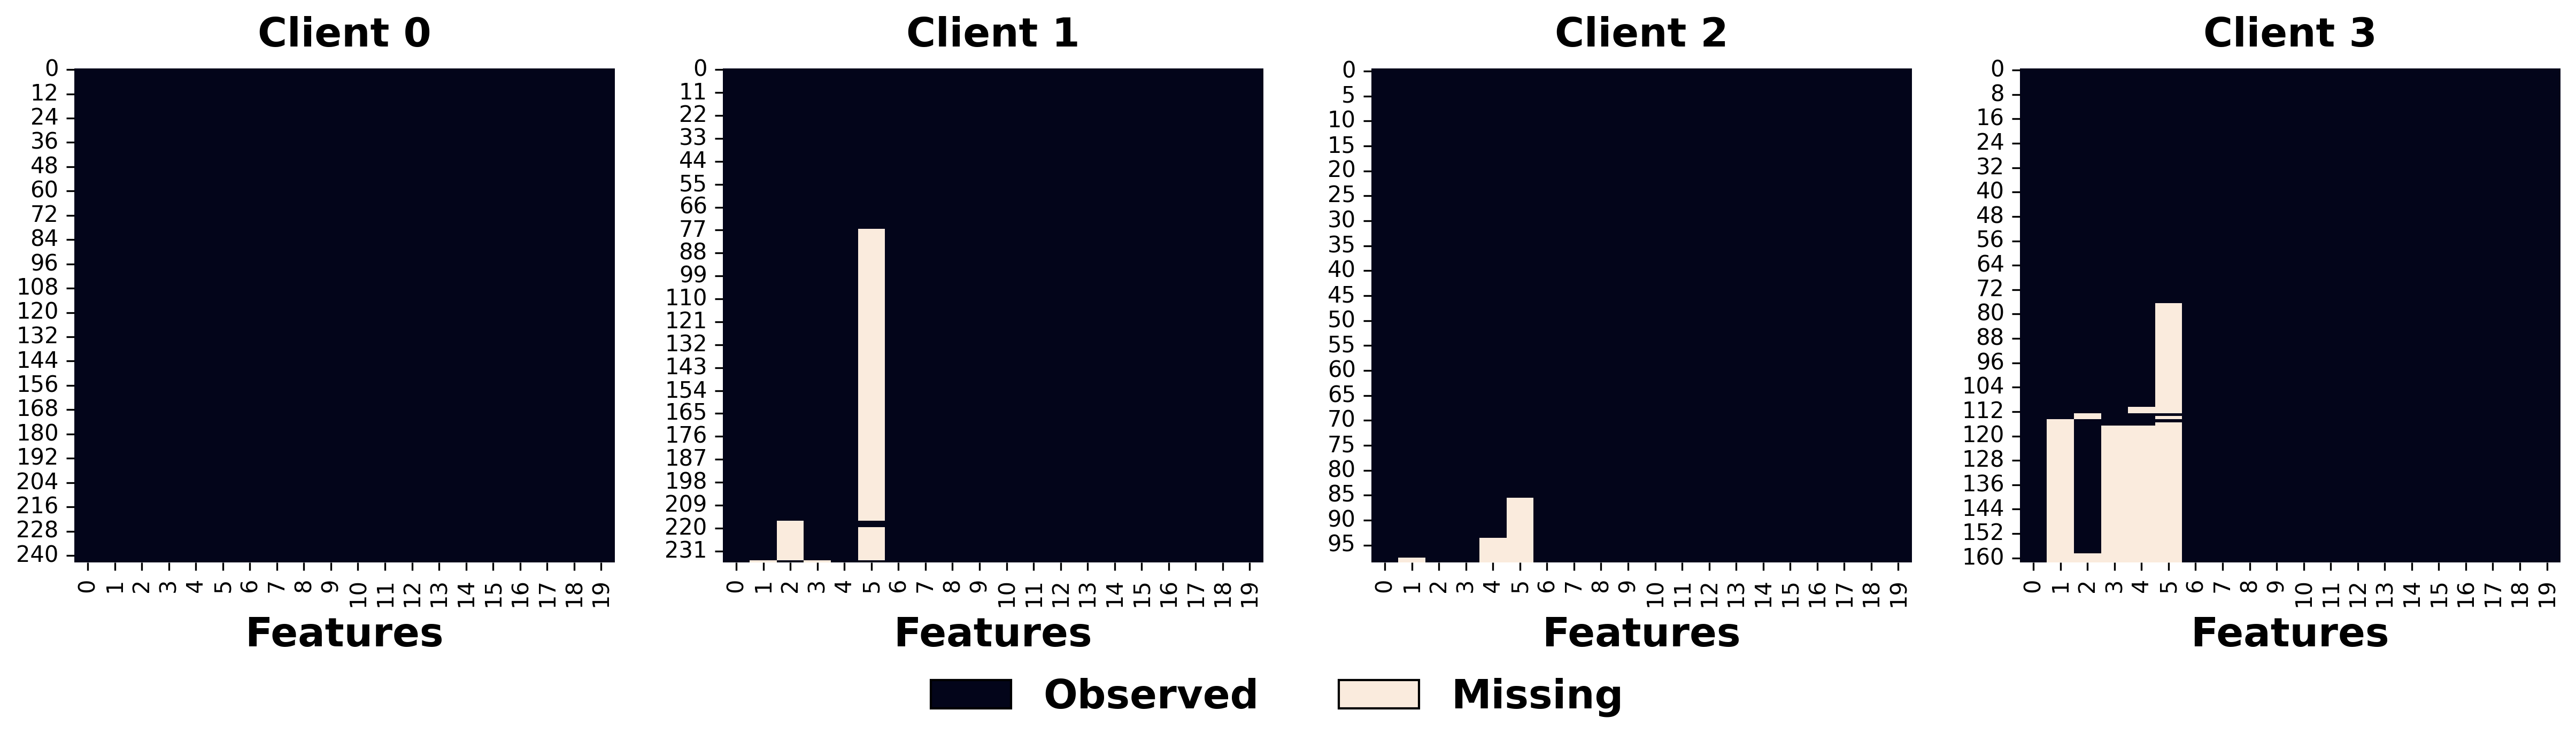

In [47]:
simulator.visualize_missing_pattern(client_ids=[0, 1, 2, 3], data_type='train')

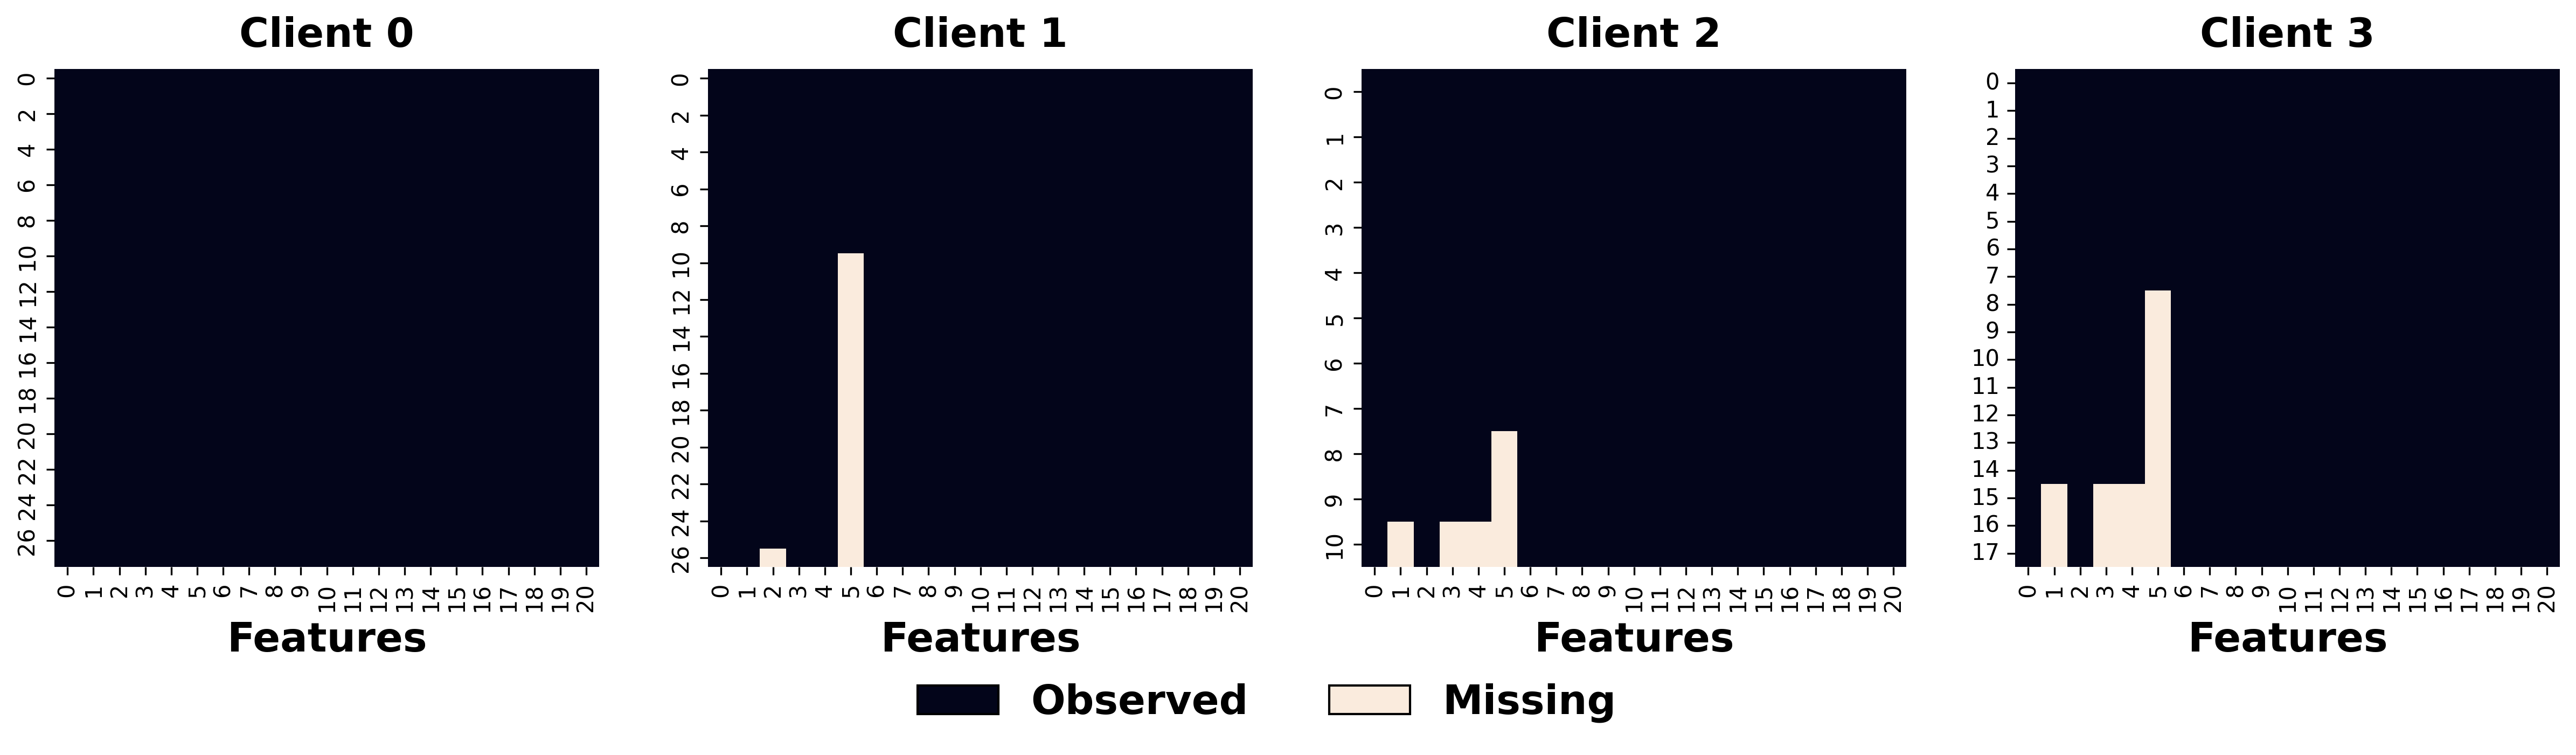

In [48]:
simulator.visualize_missing_pattern(client_ids=[0, 1, 2, 3], data_type='test')

# Running Federated Imputation

In [44]:
%load_ext autoreload
%autoreload 2
from fedimpute.execution_environment import FedImputeEnv

env = FedImputeEnv(debug_mode=False)
env.configuration(imputer = 'miwae', fed_strategy='fedavg', workflow_params = {})
env.setup_from_simulator(simulator = simulator, verbose=1)
env.show_env_info()
env.run_fed_imputation(verbose=2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setting up clients...
Setting up server...
Setting up workflow...
Environment setup complete.
Environment Information:
Workflow: JM (Joint Modeling)
Clients:
 - Client 0: imputer: miwae, fed-strategy: fedavg
 - Client 1: imputer: miwae, fed-strategy: fedavg
 - Client 2: imputer: miwae, fed-strategy: fedavg
 - Client 3: imputer: miwae, fed-strategy: fedavg
Server: fed-strategy: fedavg

Imputation Start ...
Initial Imputation.


Global Epoch:   0%|          | 0/300 [00:00<?, ?it/s]


Loss: 18.31 (2.043774)

Loss: 13.85 (0.798748)

Loss: 12.46 (0.831495)

Loss: 11.12 (0.877185)

Loss: 9.79 (0.944498)

Loss: 8.45 (1.060592)

Loss: 6.99 (1.253972)

Loss: 5.30 (1.507776)

Loss: 3.40 (1.857596)

Loss: 1.49 (2.279032)

Loss: 0.74 (2.278526)

Loss: 0.26 (2.399818)

Loss: -0.00 (2.506351)

Loss: -0.22 (2.600620)

Loss: -0.40 (2.669553)

Loss: -0.54 (2.730772)

Loss: -0.43 (2.664497)

Loss: -0.75 (2.754663)

Loss: -0.86 (2.711052)

Loss: -0.99 (2.702256)

Loss: -0.99 (2.614097)

Loss: -1.20 (2.582719)

Loss: -1.34 (2.572736)

Loss: -1.46 (2.566371)

Loss: -1.61 (2.551252)

Loss: -1.76 (2.572419)

Loss: -1.88 (2.497376)

Loss: -2.04 (2.526581)

Loss: -2.24 (2.540215)

Loss: -2.38 (2.556259)
start fine tuning ...


Fine Tuning Epoch: 0it [00:00, ?it/s]

Final Round ...
Finished. Running time: 286.3162 seconds


## Monitoring Imputation Progress


# Evaluation

In [45]:
%load_ext autoreload
%autoreload 2
from fedimpute.evaluation import Evaluator

evaluator = Evaluator()

X_trains, y_trains = env.get_data(client_ids='all', data_type = 'train', include_y=True)
X_tests, y_tests = env.get_data(client_ids='all', data_type = 'test', include_y=True)
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')
X_test_imps = env.get_data(client_ids='all', data_type = 'test_imp')
data_config = env.get_data(data_type = 'config')

ret = evaluator.evaluate_local_pred(
    X_train_imps = X_train_imps,
    y_trains = y_trains,
    X_tests = X_test_imps,
    y_tests = y_tests,
    data_config = data_config,
    model = 'nn',
    seed= 0
)
evaluator.show_local_pred_results()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Clients:   0%|          | 0/4 [00:00<?, ?it/s]

Early stopping at epoch 316
Early stopping at epoch 227
Early stopping at epoch 410
Early stopping at epoch 211
Downstream Prediction (Local)
             accuracy       f1         auc         prc
----------  ----------  ----------  ----------  ----------
 Client 1     0.607       0.645       0.708       0.742
 Client 2     0.852       0.778       0.953       0.933
 Client 3     0.909       0.952       0.800       0.981
 Client 4     0.667       0.800       0.538       0.741
----------  ----------  ----------  ----------  ----------
 Average      0.759       0.794       0.750       0.849
   Std        0.125       0.109       0.150       0.109


### Federated Prediction

In [46]:
X_train_imps = env.get_data(client_ids='all', data_type = 'train_imp')
X_test_imps = env.get_data(client_ids='all', data_type = 'test_imp')
X_global_test_imp = env.get_data(data_type = 'global_test_imp')

_ , y_trains = env.get_data(
    client_ids='all', data_type = 'train', include_y=True
)
_ , y_tests = env.get_data(
    client_ids='all', data_type = 'test', include_y=True
)
_, y_global_test = env.get_data(
    data_type = 'global_test', include_y = True
)
data_config = env.get_data(data_type = 'config')

ret = evaluator.evaluate_fed_pred(
    X_train_imps = X_train_imps,
    y_trains = y_trains,
    X_tests = X_test_imps,
    y_tests = y_tests,
    X_test_global = X_global_test_imp,
    y_test_global = y_global_test,
    data_config = data_config,
    train_params = {
        'global_epoch': 100,
        'local_epoch': 10,
        'fine_tune_epoch': 200,
    },
    seed= 0
)

evaluator.show_fed_pred_results()

Global Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - average loss: 0.6503049905101458
Epoch 10 - average loss: 0.5918659542997678
Early stopping at epoch 11
Epoch 20 - average loss: 0.5441961718930138
Epoch 30 - average loss: 0.5479142235385047
Early stopping at epoch 30
Epoch 40 - average loss: 0.5102953712145487
Early stopping at epoch 49
Epoch 50 - average loss: 0.48717724283536273
Early stopping at epoch 51
Early stopping at epoch 72
Early stopping at epoch 171
Downstream Prediction (Fed)
 Personalized    accuracy       f1         auc         prc
--------------  ----------  ----------  ----------  ----------
   Client 1       0.679       0.710       0.815       0.838
   Client 2       0.889       0.824       0.976       0.962
   Client 3       0.909       0.952       0.700       0.970
   Client 4       0.833       0.897       0.538       0.726
  ----------    ----------  ----------  ----------  ----------
    Global        0.798       0.812       0.875       0.863
